In [1]:
import numpy as np
import geopandas as gpd
import dill
import matplotlib.pyplot as plt
import numpy.ma as ma
from discretize import TensorMesh
from ipywidgets import widgets, interact

In [2]:
output_dict = dill.load(open("output_metric_maps.pik", "rb"))

In [3]:
fc_thresholds = [0.2, 0.5, 0.8]
fc = output_dict['fc']

In [4]:
thres = fc_thresholds[0]
path_length_norm = output_dict['path_length_norm'][thres]
path_to_no_flow = output_dict['path_to_no_flow'][thres]

thres_path_length_norm = 50.
thres_path_to_no_flow = 10.
fc_threshold = 0.8

def get_summary_metric_map(fc_threshold, thres_path_length_norm, path_to_no_flow):
    inds_all = np.logical_and(fc.data>fc_threshold, path_length_norm.data<thres_path_length_norm, path_to_no_flow.data>thres_path_to_no_flow)
    summary_metric_up = inds_all.astype(float)
    summary_metric_up = ma.masked_array(data=summary_metric_up, mask=fc.mask)
    return summary_metric_up

In [5]:
mesh_orig = TensorMesh.read_UBC("./mesh_orig.msh")

In [ ]:
import matplotlib.pyplot as plt
plt.pcolormesh(mesh_orig.cell_centers_y, mesh_orig.cell_centers_x, mesh_orig.reshape())

NameError: name 'test' is not defined

In [40]:
mesh_orig.nodes_x

array([-2.27093797e+05, -2.26693797e+05, -2.26293797e+05, -2.25893797e+05,
       -2.25493797e+05, -2.25093797e+05, -2.24693797e+05, -2.24293797e+05,
       -2.23893797e+05, -2.23493797e+05, -2.23093797e+05, -2.22693797e+05,
       -2.22293797e+05, -2.21893797e+05, -2.21493797e+05, -2.21093797e+05,
       -2.20693797e+05, -2.20293797e+05, -2.19893797e+05, -2.19493797e+05,
       -2.19093797e+05, -2.18693797e+05, -2.18293797e+05, -2.17893797e+05,
       -2.17493797e+05, -2.17093797e+05, -2.16693797e+05, -2.16293797e+05,
       -2.15893797e+05, -2.15493797e+05, -2.15093797e+05, -2.14693797e+05,
       -2.14293797e+05, -2.13893797e+05, -2.13493797e+05, -2.13093797e+05,
       -2.12693797e+05, -2.12293797e+05, -2.11893797e+05, -2.11493797e+05,
       -2.11093797e+05, -2.10693797e+05, -2.10293797e+05, -2.09893797e+05,
       -2.09493797e+05, -2.09093797e+05, -2.08693797e+05, -2.08293797e+05,
       -2.07893797e+05, -2.07493797e+05, -2.07093797e+05, -2.06693797e+05,
       -2.06293797e+05, -

In [7]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0.5, 0),    # Green
          (1, 1, 1)]    # White
positions = [0, 1]
green_map = LinearSegmentedColormap.from_list("green_white", list(zip(positions, colors)))

colors = [(1, 1, 1),    # Green
          (0, 0.5, 0)]    # White
positions = [0, 1]
green_r_map = LinearSegmentedColormap.from_list("green_white", list(zip(positions, colors)))

# Extract RGB values from the predefined RdBu colormap
cmap = plt.get_cmap('RdBu')

# Create a list of colors by sampling the colormap
colors = [cmap(i) for i in range(cmap.N)]

# Create the custom colormap
custom_rdbu = LinearSegmentedColormap.from_list("custom_rdbu", np.array(colors)[20:-20][::-1])

import matplotlib.colors
binary_cmap = matplotlib.colors.ListedColormap(['white', 'green'])

In [8]:
import rasterio
from rasterio.plot import show
data_dir = "/Users/juliusbusecke/Library/Caches/em_recharge/data_download"
src = rasterio.open(f"{data_dir}/data/cv_terrain.tiff")
gdf_rivers = gpd.read_file(f"{data_dir}/data/shp/cv_rivers.geojson")
gdf_rivers_3310 = gdf_rivers.to_crs(3310)
gdf_rho_salinity = gpd.read_file(f"{data_dir}/data/shp/rho_salinity_boundary/rho_salinity_boundary.shp")
gdf_subbasin_cv = gpd.read_file(f"{data_dir}/data/shp/subbasins/subbasins_cv.shp")

In [9]:
import xarray as xr
src_xr = xr.open_dataset(f"{data_dir}/data/cv_terrain.tiff", engine="rasterio")
src_xr

<xarray.Dataset> Size: 205MB
Dimensions:      (band: 4, x: 3450, y: 3721)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 28kB -3.944e+05 -3.942e+05 ... 2.768e+05 2.77e+05
  * y            (y) float64 30kB 3.274e+05 3.272e+05 ... -3.966e+05 -3.968e+05
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 205MB ...

In [20]:
f"{data_dir}/data/cv_terrain.tiff"


'/Users/juliusbusecke/Library/Caches/em_recharge/data_download/data/cv_terrain.tiff'

In [21]:
!gdalinfo /Users/juliusbusecke/Library/Caches/em_recharge/data_download/data/cv_terrain.tiff

Driver: GTiff/GeoTIFF
Files: /Users/juliusbusecke/Library/Caches/em_recharge/data_download/data/cv_terrain.tiff
Size is 3450, 3721
Coordinate System is:
PROJCRS["NAD83 / California Albers",
    BASEGEOGCRS["NAD83",
        DATUM["North American Datum 1983",
            ELLIPSOID["GRS 1980",6378137,298.257222101,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4269]],
    CONVERSION["California Albers",
        METHOD["Albers Equal Area",
            ID["EPSG",9822]],
        PARAMETER["Latitude of false origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8821]],
        PARAMETER["Longitude of false origin",-120,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8822]],
        PARAMETER["Latitude of 1st standard parallel",34,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8823]],
        PARAMETER["Latitude of

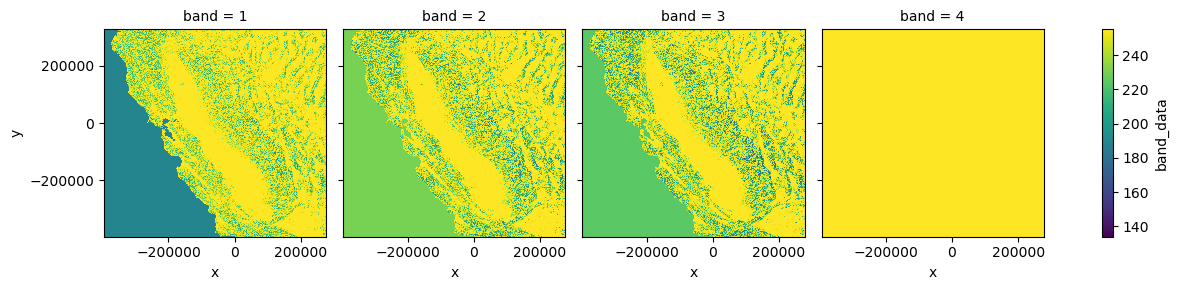

In [10]:
t = src_xr.rio
t.bounds()
# t.reproject("EPSG:4326")['band_data'].plot(col='band')
src_xr['band_data'].plot(col='band')


In [11]:
src_xr.rio

In [12]:
from matplotlib.colors import LogNorm

In [13]:
options_path_length_norm = [1, 2, 5, 20, 100]
options_path_to_no_flow = [1, 5, 10, 20, 40]

def foo(metric_map, thres_fc, show_brackish_region, show_subbasins, show_rivers, show_terrain):

    fig, ax = plt.subplots(1,1, figsize=(5, 8))
    if show_terrain:
        show(src, ax=ax, alpha=1)
    
    path_length_norm = output_dict['path_length_norm'][thres_fc]
    path_to_no_flow = output_dict['path_to_no_flow'][thres_fc]

    if metric_map == 'fcd':
        cmap = custom_rdbu
        values = fc.copy() * 100
        norm = None
        vmin, vmax = 0, 100
        clim = (vmin, vmax)
        norm = None    
        label = "Averaged FCD (%)"
    elif metric_map == 'path_length_norm':
        cmap = green_map
        values = path_length_norm.copy()
        vmin, vmax = 1, 1000
        clim = None
        norm = LogNorm(vmin=vmin, vmax=vmax)
        label = "Normalized path length"
    elif metric_map == 'path_to_no_flow':
        cmap = green_r_map
        values = path_to_no_flow.copy()
        vmin, vmax = 0, 20
        clim = (vmin, vmax)
        norm = None
        label = "Depth to shallowest no-flow or base (m)"
    elif metric_map == 'summary':        
        cmap = binary_cmap
        values = get_summary_metric_map(thres_fc, thres_path_length_norm, path_to_no_flow)
        vmin, vmax = 0, 1
        clim = (vmin, vmax)
        norm = None
        label = "Summary"
    
    out = mesh_orig.plot_image(values, ax=ax, clim=clim, pcolor_opts={'cmap':cmap, 'norm':norm})

    if show_brackish_region:
        gdf_rho_salinity.plot(ax=ax, legend=True, color='grey')
    if show_rivers:
        gdf_rivers_3310.plot(color='blue', linewidth=0.3, ax=ax, alpha=0.8, label='Rivers & streams')
    if show_subbasins:
        gdf_subbasin_cv.boundary.plot(color='k', linewidth=0.3, ax=ax, label='Subbasin boundaries')
        
    cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, pad=0.02, ax=ax)
    if metric_map == 'summary':
        cb.set_ticks([0.25, 0.75])
        cb.set_ticklabels(["Unsuitable", "Suitable"])
        cb.set_label(" ")        
    else:
        cb.set_label(label)    
    
    # ax.set_title(title)
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_yticks([])  
    ax.set_xlabel("")
    ax.set_ylabel("")    
    # ax.axis('off')
    ax.set_aspect(1)
    ax.set_facecolor('lightgrey')
    plt.tight_layout()

In [ ]:
interact(
    foo,
    metric_map=widgets.Select(options=['fcd', 'path_length_norm', 'path_to_no_flow', 'summary']),
    thres_fc=widgets.SelectionSlider(options=[('20%', 0.2), ('50%', 0.5), ('80%', 0.8)], value=0.5), 
    # thres_path_length_norm=widgets.SelectionSlider(options=options_path_length_norm, value=20),
    # thres_path_to_no_flow=widgets.SelectionSlider(options=options_path_to_no_flow, value=10),
    show_brackish_region=widgets.Checkbox(value=True),
    show_subbasins=widgets.Checkbox(value=False),
    show_rivers=widgets.Checkbox(value=False),
    show_terrain=widgets.Checkbox(value=False)
)

interactive(children=(Select(description='metric_map', options=('fcd', 'path_length_norm', 'path_to_no_flow', …

<function __main__.foo(metric_map, thres_fc, show_brackish_region, show_subbasins, show_rivers, show_terrain)>